In [9]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from stanza.reporting.local import LocalDatabase
from stanza.util.logging import logger
from stanza import Partial, partial
from stanza.policies import rollout
from pathlib import Path
from diffusion_policy import make_network, make_diffuser, make_policy_transform
from stanza.policies.diffusion import make_diffusion_policy
from jax.random import PRNGKey
from stanza.solver.ilqr import iLQRSolver
from stanza.policies.mpc import MPC
import stanza.policies as policies
import stanza.envs as envs

env = envs.create("quadrotor")
db = LocalDatabase(path=Path("..") / "results")
action_sample = env.sample_action(PRNGKey(0))
solver = iLQRSolver()
mpc = MPC(
    action_sample=action_sample,
    cost_fn=env.cost,
    model_fn=env.step,
    horizon_length=100,
    receed=True,
    solver=iLQRSolver()
)

In [11]:
from stanza.util.random import PRNGSequence
from jax.random import PRNGKey
import jax
import jax.numpy as jnp

def rollout_final(result, rng_key, trajs):
    rng_seq = PRNGSequence(rng_key)
    config = result.get("config")
    params = result.get("final_checkpoint_ema")
    normalizer = result.get("normalizer")
    net = make_network(config)
    net_fn = Partial(net.apply, params)
    diffuser = make_diffuser(config)
    replica_policy = make_diffusion_policy(
        net_fn, diffuser, normalizer, 16, 1, 8,
        noise=config.smoothing_sigma,
        diffuse_gains=config.use_gains,
    )
    deconv_policy = make_diffusion_policy(
        net_fn, diffuser, normalizer, 16, 1, 8,
        diffuse_gains=config.use_gains,
    )
    replica_policy = make_policy_transform(config)(replica_policy)
    deconv_policy = make_policy_transform(config)(deconv_policy)
    def rollout(policy, x0_rng, policy_rng):
        x0 = env.reset(x0_rng)
        return policies.rollout(env.step, x0, policy,
                policy_rng_key=policy_rng, length=100)
    deconv_rollout_fn = partial(rollout, deconv_policy)
    replica_rollout_fn = partial(rollout, replica_policy)
    mpc_rollout_fn = partial(rollout, mpc)
    mapped_replica_fun = jax.jit(jax.vmap(replica_rollout_fn, in_axes=(None, 0)))
    mapped_deconv_fun = jax.jit(jax.vmap(deconv_rollout_fn, in_axes=(None, 0)))
    mapped_mpc_fun = jax.jit(jax.vmap(mpc_rollout_fn, in_axes=(None, 0)))

    #x0_rngs = jax.random.split(next(rng_seq), trajs)
    x0_rngs = next(rng_seq)

    replica_rngs = jax.random.split(next(rng_seq), trajs)
    deconv_rngs = jax.random.split(next(rng_seq), trajs)

    replica_trajs = mapped_replica_fun(x0_rngs, replica_rngs)
    deconv_trajs = mapped_deconv_fun(x0_rngs, deconv_rngs)
    mpc_trajs = mapped_mpc_fun(x0_rngs, deconv_rngs)
    return mpc_trajs, deconv_trajs, replica_trajs

In [12]:
import matplotlib.pyplot as plt

result = db.open("diffusion_policy").open("northern-breeze-50")
# result = db.open("diffusion_policy").open("wise-vortex-47")
mpc_trajs, deconv_trajs, replica_trajs = rollout_final(result, PRNGKey(41), 20)

[20:03:05] TRACE  - <Tracing> Tracing model                                                          ]8;id=156654;file:///home/daniel/Documents/code/stable_imitation/stanza/projects/diffusion_policy/networks.py\networks.py]8;;\:]8;id=930288;file:///home/daniel/Documents/code/stable_imitation/stanza/projects/diffusion_policy/networks.py#24\24]8;;\

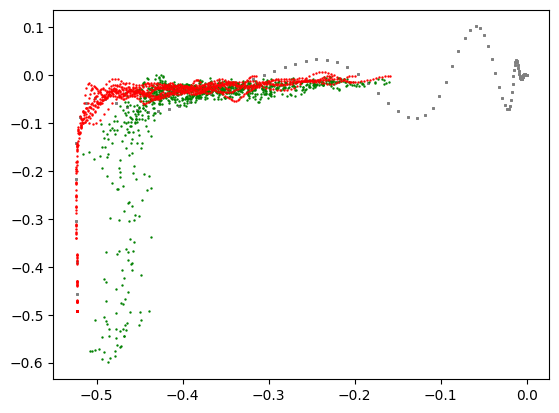

In [13]:
def plot_trajs(trajs, color, ref_color, use_cmap=False):
    trajs = jax.tree_map(lambda x: x[:10], trajs)
    t = jnp.arange(trajs.states.x.shape[1])
    t_actions = jnp.arange(trajs.states.x.shape[1] - 1)
    t = jnp.repeat(jnp.expand_dims(t, 0), trajs.states.x.shape[0], axis=0)
    t_actions = jnp.repeat(jnp.expand_dims(t_actions, 0),
                           trajs.states.x.shape[0], axis=0)
    x = trajs.states.x.reshape(-1)
    y = trajs.states.z.reshape(-1)
    t = t.reshape(-1)
    t_actions = t_actions.reshape(-1)
    if 'ref_state' in trajs.info:
        ref_x = trajs.info.ref_state.x.reshape(-1)
        ref_y = trajs.info.ref_state.z.reshape(-1)
        if use_cmap:
            plt.scatter(ref_x, ref_y, c=t_actions, cmap=ref_color, s=0.5)
        else:
            plt.scatter(ref_x, ref_y, color=ref_color, s=0.5)
    if use_cmap:
        plt.scatter(x, y, c=t, cmap=color, s=0.5)
    else:
        plt.scatter(x, y, color=color, s=0.5)
plot_trajs(mpc_trajs, "grey", "yellow")
# plot_trajs(deconv_trajs, "blue", "purple")
plot_trajs(replica_trajs, "red", "green")

In [14]:
# import jax

# results = db.open("diffusion_policy")

# x0_rngs = jax.random.split(PRNGKey(42), 20)
# for c in results.children:
#     print(f"Running {c}")
#     result = results.open(c)